# **EVALUACIÓN FINAL: ANÁLISIS DE MOVIMIENTOS MIGRATORIOS CON SPARK**
Eres parte de un equipo de analistas de datos encargado de estudiar las tendencias de migración humana en el siglo XXI utilizando Big Data. Para ello, trabajarás con un conjunto de datos que contiene información sobre migraciones entre distintos países, sus causas y el impacto socioeconómico en las regiones de origen y destino.

**Objetivos de la actividad**

1. Aplicar conceptos de Big Data utilizando Apache Spark y PySpark.
2. Explorar y transformar datos con RDDs y DataFrames.
3. Realizar consultas con Spark SQL.
4. Implementar modelos de aprendizaje automático con MLlib.

**INSTRUCCIONES**

**1. Carga y exploración de datos (2 puntos)**
* Carga el dataset proporcionado en Spark.
* Convierte los datos en un RDD y un DataFrame.
* Explora los datos: muestra las primeras filas, el esquema y genera estadísticas descriptivas.

**2. Procesamiento de datos con RDDs y DataFrames (3 puntos)**
* Aplica transformaciones sobre los RDDs (filter, map, flatMap).
* Aplica acciones sobre los RDDs (collect, take, count).
* Realiza operaciones con DataFrames: filtrado, agregaciones y ordenamiento.
* Escribe los resultados en formato Parquet.

**3. Consultas con Spark SQL (2 puntos)**
* Registra el DataFrame como una tabla temporal.
* Realiza consultas sobre los principales países de origen y destino.
* Analiza las principales razones de migración por región.

**4. Aplicación de MLlib para predicción de flujos migratorios (3 puntos)**
* Convierte los datos en un formato adecuado para MLlib.
* Aplica un modelo de regresión logística para predecir la probabilidad de migración basada
en factores socioeconómicos.
* Evalúa el modelo y analiza su precisión.


In [48]:
from pyspark.sql import SparkSession
import re
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
import matplotlib.pyplot as plt


In [25]:
# -----------------------------
# 1. Carga y exploración de datos
# -----------------------------


spark = SparkSession.builder.appName("AnalisisMigraciones").getOrCreate()
df = spark.read.csv("migraciones.csv", header=True, inferSchema=True)


# Convertimos a RDD (colección distribuida de filas)
rdd = df.rdd

# Mostramos primeras filas (head) del DataFrame
print("=== Primeras filas del DataFrame ===")
df.show()

# Mostramos el esquema (columnas y tipos)
print("=== Esquema del DataFrame ===")
df.printSchema()

# Estadísticas descriptivas (para columnas numéricas)
print("=== Estadísticas descriptivas ===")
df.describe().show(truncate=False)



=== Primeras filas del DataFrame ===
+---+---------+---------------+----+---------+----------+-----------+---------------------+----------------------+----------------------+-----------------------+----------------+-----------------+
| ID|   Origen|        Destino| Año|    Razón|PIB_Origen|PIB_Destino|Tasa_Desempleo_Origen|Tasa_Desempleo_Destino|Nivel_Educativo_Origen|Nivel_Educativo_Destino|Población_Origen|Población_Destino|
+---+---------+---------------+----+---------+----------+-----------+---------------------+----------------------+----------------------+-----------------------+----------------+-----------------+
|  1|   México|           EEUU|2015|Económica|      8900|      62000|                  5.2|                   3.8|                   8.5|                   12.3|       125000000|        331000000|
|  2|    Siria|       Alemania|2016|Conflicto|      2500|      45000|                 15.4|                   4.5|                   6.2|                   14.1|        180000

In [26]:
# -----------------------------
# 2. Procesamiento con RDDs y DataFrames
# -----------------------------

# transforma
cols_objetivo = ["PIB_Origen", "PIB_Destino"]

df_num = df
# Construimos una columna combinada con los dos PIBs para calcular cuartiles globales
union_pib = (
    df_num.select(F.col("PIB_Origen").alias("pib"))
    .unionByName(df_num.select(F.col("PIB_Destino").alias("pib")))
    .filter(F.col("pib").isNotNull())
)

q1, q2, q3 = union_pib.approxQuantile("pib", [0.25, 0.5, 0.75], 0.01)
print(f"Umbrales globales -> Q1={q1:.2f}, Q2={q2:.2f}, Q3={q3:.2f}")

# Función para categorizar usando los mismos umbrales
def categorizar_con_cortes(df_in, col, q1, q2, q3):
    return df_in.withColumn(
        f"{col}_categoria",
        F.when(F.col(col).isNull(), None)
         .when(F.col(col) <= q1, "Bajo")
         .when(F.col(col) <= q2, "Medio Bajo")
         .when(F.col(col) <= q3, "Medio Alto")
         .otherwise("Alto")
    )

df_cat = df_num
for c in cols_objetivo:
    if c in df_cat.columns:
        df_cat = categorizar_con_cortes(df_cat, c, q1, q2, q3)


df_cat.show()


Umbrales globales -> Q1=6000.00, Q2=10000.00, Q3=43000.00
+---+---------+---------------+----+---------+----------+-----------+---------------------+----------------------+----------------------+-----------------------+----------------+-----------------+--------------------+---------------------+
| ID|   Origen|        Destino| Año|    Razón|PIB_Origen|PIB_Destino|Tasa_Desempleo_Origen|Tasa_Desempleo_Destino|Nivel_Educativo_Origen|Nivel_Educativo_Destino|Población_Origen|Población_Destino|PIB_Origen_categoria|PIB_Destino_categoria|
+---+---------+---------------+----+---------+----------+-----------+---------------------+----------------------+----------------------+-----------------------+----------------+-----------------+--------------------+---------------------+
|  1|   México|           EEUU|2015|Económica|      8900|      62000|                  5.2|                   3.8|                   8.5|                   12.3|       125000000|        331000000|          Medio Bajo|     

In [27]:

# ==========================================================
# 1) RDDs: transformaciones (filter, map, flatMap) + acciones
# ==========================================================
# Partimos de un RDD con Origen, Destino y Razón
rdd = df_cat.select("Origen", "Destino", "Razón").rdd

# filter: descartar registros nulos y rutas Origen==Destino
rdd_filtrado = rdd.filter(lambda r: r[0] and r[1] and (r[0] != r[1]))

# map: construir una cadena "origen->destino" en minúsculas
rdd_rutas = rdd_filtrado.map(lambda r: f"{str(r[0]).strip().lower()}->{str(r[1]).strip().lower()}")

# flatMap: tokenizar la columna Razón en múltiples tokens (separadores: , ; / y)
splitter = re.compile(r"[,\;/]| y ")
rdd_tokens = rdd_filtrado.flatMap(
    lambda r: [t.strip().lower() for t in (splitter.split(r[2]) if r[2] else []) if t.strip()]
)

# Acciones: count, take, collect (usa collect con cuidado si hay muchos datos)
print("=== Acciones RDD ===")
print("count(rutas):", rdd_rutas.count())
print("take(rutas, 5):", rdd_rutas.take(5))
print("take(tokens, 20):", rdd_tokens.take(20))
# tokens_all = rdd_tokens.collect()  # evitar en datasets grandes


=== Acciones RDD ===
count(rutas): 5
take(rutas, 5): ['méxico->eeuu', 'siria->alemania', 'venezuela->colombia', 'india->emiratos árabes', 'argentina->españa']
take(tokens, 20): ['económica', 'conflicto', 'política', 'laboral', 'económica']


In [28]:

# =======================================================
# 4. DataFrames: filtrado, agregaciones y ordenamiento
# =======================================================
# Filtro: registros válidos a partir de 2015 con Origen y Destino no nulos
df_filtrado = (
    df_cat.filter(F.col("Origen").isNotNull() & F.col("Destino").isNotNull())
      .filter(F.col("Año") >= 2015)
)

# Agregaciones: por Origen, Destino y categorías de PIB
agg = (
    df_filtrado.groupBy( "PIB_Origen_categoria")
               .agg(
                   F.count("*").alias("registros"),
                   F.avg("PIB_Origen").alias("PIB_Origen_prom"),
                   F.avg("PIB_Destino").alias("PIB_Destino_prom")
               )
)


agg2 = (
    df_filtrado.groupBy( "PIB_Destino_categoria")
               .agg(
                   F.count("*").alias("registros"),
                   F.avg("PIB_Origen").alias("PIB_Origen_prom"),
                   F.avg("PIB_Destino").alias("PIB_Destino_prom")
               )
)

# Ordenamiento: primero por número de registros y luego por PIB_Destino promedio
agg_ordenado = agg.orderBy(F.col("registros").desc(), F.col("PIB_Origen_prom").desc())

print("=== Agregaciones ordenadas (top 20) ===")
agg_ordenado.show(20, truncate=False)

# Ordenamiento: primero por número de registros y luego por PIB_Destino promedio
agg_ordenado2 = agg2.orderBy(F.col("registros").desc(), F.col("PIB_Destino_prom").desc())

print("=== Agregaciones ordenadas (top 20) ===")
agg_ordenado2.show(20, truncate=False)


=== Agregaciones ordenadas (top 20) ===
+--------------------+---------+------------------+------------------+
|PIB_Origen_categoria|registros|PIB_Origen_prom   |PIB_Destino_prom  |
+--------------------+---------+------------------+------------------+
|Bajo                |3        |3566.6666666666665|34333.333333333336|
|Medio Bajo          |2        |9450.0            |48000.0           |
+--------------------+---------+------------------+------------------+

=== Agregaciones ordenadas (top 20) ===
+---------------------+---------+-----------------+------------------+
|PIB_Destino_categoria|registros|PIB_Origen_prom  |PIB_Destino_prom  |
+---------------------+---------+-----------------+------------------+
|Medio Alto           |3        |6066.666666666667|30666.666666666668|
|Alto                 |2        |5700.0           |53500.0           |
+---------------------+---------+-----------------+------------------+



In [29]:
# ===================================
# 5. Escritura de resultados a Parquet
# ===================================
# 3.1) Agregaciones
agg_ordenado.write.mode("overwrite").parquet("/salida2/agg_PIBorigenes.parquet")
agg_ordenado2.write.mode("overwrite").parquet("/salida2/agg_PIBdestinos.parquet")

# 3.2) Tokens de razones (convertimos RDD -> DataFrame para poder escribir)
df_tokens = spark.createDataFrame(rdd_tokens.map(lambda x: (x,)), ["razon_token"])
df_tokens.write.mode("overwrite").parquet("/salida2/razones_tokens.parquet")

# 3.3) Rutas únicas (RDD -> DataFrame)
df_rutas = spark.createDataFrame(rdd_rutas.distinct().map(lambda x: (x,)), ["ruta"])
df_rutas.write.mode("overwrite").parquet("/salida2/rutas.parquet")

print("Parquet escritos en: salida/ (agg_rutas.parquet, razones_tokens.parquet, rutas.parquet)")



Parquet escritos en: salida/ (agg_rutas.parquet, razones_tokens.parquet, rutas.parquet)


In [32]:
# ====================================================
# 6. SparkSQL
# ====================================================

# ====================================================
# Registrar el DataFrame como tabla temporal (SQL)
# ====================================================
df_cat.show()
df_cat.createOrReplaceTempView("migraciones")

# ==========================================================
# Consultas: principales países de ORIGEN y de DESTINO
# ==========================================================

print("=== Top 2 países de ORIGEN ===")
spark.sql("""
    SELECT Origen AS origen, COUNT(*) AS conteo
    FROM migraciones
    WHERE Origen IS NOT NULL
    GROUP BY Origen
    ORDER BY conteo DESC
    LIMIT 2
""").show(truncate=False)

print("=== Top 2 países de DESTINO ===")
spark.sql("""
    SELECT Destino AS destino, COUNT(*) AS conteo
    FROM migraciones
    WHERE Destino IS NOT NULL
    GROUP BY Destino
    ORDER BY conteo DESC
    LIMIT 2
""").show(truncate=False)


df = df.withColumn(
    "razon_bin",
    F.when(F.col("Razón") == F.lit("Económica"), F.lit(1)).otherwise(F.lit(0))
)
feature_cols = [
    "PIB_Origen","PIB_Destino",
    "Tasa_Desempleo_Origen","Tasa_Desempleo_Destino",
    "Nivel_Educativo_Origen","Nivel_Educativo_Destino",
    "Población_Origen","Población_Destino"
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_ass = assembler.transform(df)

df_ass = df_ass.select("PIB_Origen","PIB_Destino","features", "razon_bin")

df_ass.show()


+---+---------+---------------+----+---------+----------+-----------+---------------------+----------------------+----------------------+-----------------------+----------------+-----------------+--------------------+---------------------+
| ID|   Origen|        Destino| Año|    Razón|PIB_Origen|PIB_Destino|Tasa_Desempleo_Origen|Tasa_Desempleo_Destino|Nivel_Educativo_Origen|Nivel_Educativo_Destino|Población_Origen|Población_Destino|PIB_Origen_categoria|PIB_Destino_categoria|
+---+---------+---------------+----+---------+----------+-----------+---------------------+----------------------+----------------------+-----------------------+----------------+-----------------+--------------------+---------------------+
|  1|   México|           EEUU|2015|Económica|      8900|      62000|                  5.2|                   3.8|                   8.5|                   12.3|       125000000|        331000000|          Medio Bajo|                 Alto|
|  2|    Siria|       Alemania|2016|Conf

In [ ]:
# Join de Dataframe
df_ml = df_cat.join(df_ass, on=["PIB_Origen", "PIB_Destino"], how="inner")
train, test = df_ml.randomSplit([0.6, 0.4], seed=42)

In [50]:
# ====================================================
# 7. MLlib
# ====================================================

#================================
# Modelo de Regresión Logística
#================================

lr = LogisticRegression(labelCol="razon_bin", featuresCol="features", maxIter=50)
model = lr.fit(train)

# Predicciones
predictions = model.transform(test)

# Precisión (Accuracy), igual que en tu ejemplo
evaluator = MulticlassClassificationEvaluator(
    labelCol="razon_bin", predictionCol="prediction", metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
print(f"Precisión del modelo: {accuracy:.2f}")

# (Opcional) AUC-ROC para complementar
auc_eval = BinaryClassificationEvaluator(
    labelCol="razon_bin", rawPredictionCol="rawPrediction", metricName="areaUnderROC"
)
auc = auc_eval.evaluate(predictions)
print(f"AUC ROC: {auc:.3f}")

Precisión del modelo: 0.33
AUC ROC: 0.000


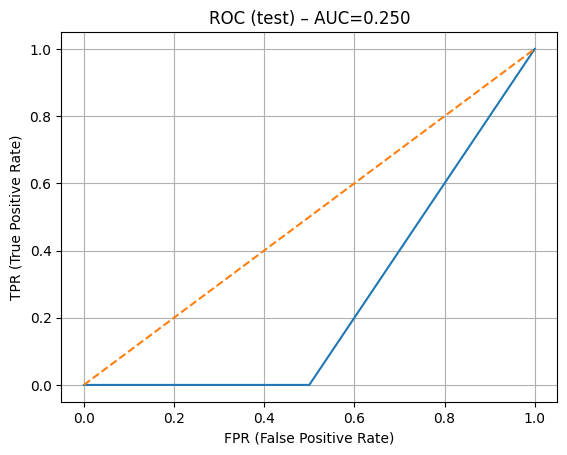

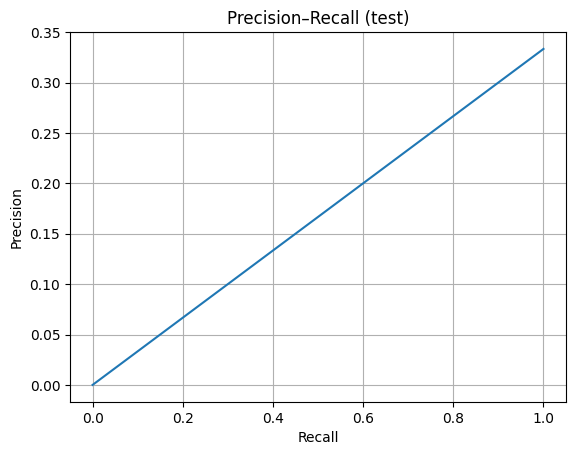

In [51]:

# 1) Curva ROC (usa el summary sobre el set de test)
summary = model.evaluate(test)  # BinaryLogisticRegressionSummary

roc_pdf = summary.roc.toPandas()
auc_roc = summary.areaUnderROC

plt.figure()
plt.plot(roc_pdf["FPR"], roc_pdf["TPR"])
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.title(f"ROC (test) – AUC={auc_roc:.3f}")
plt.grid(True)
plt.show()

# 2) Curva Precision–Recall
pr_pdf = summary.pr.toPandas()

plt.figure()
plt.plot(pr_pdf["recall"], pr_pdf["precision"])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall (test)")
plt.grid(True)
plt.show()


El Modelo de regresion tiene una precision muy baja, por lo que se evaluó con DecisionTree, que presenta un mejor valor.
De cualquier modo, para hacer un buen análisis y formular predicciones de este tipo, me parece se requieren mas datos.